# Exercise 4: Band structure calculations

In this notebook we will see, how to calculate band structures using pyiron. 

In [1]:
from pyiron.project import Project
from ase.spacegroup import crystal
import matplotlib.pyplot as plt
import seekpath as sp
import numpy as np

In [2]:
pr = Project("demo/band_structure")

In [3]:
# pr.remove_jobs(recursive=True)

## Structures with seekpath

First we see how [seekpath](https://github.com/giovannipizzi/seekpath) works! Therefore we create firts a structure using pyiron.

## Create structure with pyiron

In [4]:
structure_Fe = pr.create_structure("Fe", "bcc", 2.81)

In [5]:
structure_Fe.plot3d()

NGLWidget()

In [6]:
structure_Fe

Fe: [0. 0. 0.]
Fe: [1.405 1.405 1.405]
pbc: [ True  True  True]
cell: 
Cell([[2.81, 0.0, 0.0], [1.7206287528020313e-16, 2.81, 0.0], [1.7206287528020313e-16, 1.7206287528020313e-16, 2.81]])

## Create structure with seekpath

For seekpath we need a tuple containing
1. The cell in $3\times3$ array
2. The scaled positions
3. List of `ints` to distinguish the atom types (indices of pyiron structure)
as input structure.

In [7]:
input_sp = (structure_Fe.cell, structure_Fe.get_scaled_positions(), structure_Fe.indices)

Just to see how the output looks like, let us do...

In [8]:
sp.get_path(input_sp)

{'point_coords': {'GAMMA': [0.0, 0.0, 0.0],
  'H': [0.5, -0.5, 0.5],
  'P': [0.25, 0.25, 0.25],
  'N': [0.0, 0.0, 0.5]},
 'path': [('GAMMA', 'H'),
  ('H', 'N'),
  ('N', 'GAMMA'),
  ('GAMMA', 'P'),
  ('P', 'H'),
  ('P', 'N')],
 'has_inversion_symmetry': True,
 'augmented_path': False,
 'bravais_lattice': 'cI',
 'bravais_lattice_extended': 'cI1',
 'conv_lattice': array([[2.81, 0.  , 0.  ],
        [0.  , 2.81, 0.  ],
        [0.  , 0.  , 2.81]]),
 'conv_positions': array([[0. , 0. , 0. ],
        [0.5, 0.5, 0.5]]),
 'conv_types': array([0, 0], dtype=int32),
 'primitive_lattice': array([[-1.405,  1.405,  1.405],
        [ 1.405, -1.405,  1.405],
        [ 1.405,  1.405, -1.405]]),
 'primitive_positions': array([[0., 0., 0.]]),
 'primitive_types': array([0], dtype=int32),
 'reciprocal_primitive_lattice': [[-0.0, 2.236009006113732, 2.236009006113732],
  [2.236009006113732, 0.0, 2.236009006113732],
  [2.236009006113732, 2.236009006113732, 0.0]],
 'inverse_primitive_transformation_matrix': ar

The code creates automatically the conventional and primitive cell with all high-symmetry points and a suggested path taking all high-symmetry paths into account.

**Keep in mind:** The high-symmetry points and paths make only sence for the primitive cell! Therefore we run all calculations in the primitive cell created by seekpath.

## Create a structure

We use the same structure as before!

## Create new structure (primitive cell) with high-symmetry points and paths

For the following command all arguments valid for seekpath are supported. Look at the docstring and at seekpath.

In [9]:
structure_Fe_sp = structure_Fe.create_line_mode_structure()

In [10]:
structure_Fe_sp.plot3d()

NGLWidget()

In [11]:
structure_Fe_sp

Fe: [0. 0. 0.]
pbc: [ True  True  True]
cell: 
Cell([[-1.405, 1.405, 1.405], [1.405, -1.405, 1.405], [1.405, 1.405, -1.405]])

We see, that the structure is now the primitive cell containing only one atom.

In [12]:
structure_Fe_sp.get_high_symmetry_points()

{'GAMMA': [0.0, 0.0, 0.0],
 'H': [0.5, -0.5, 0.5],
 'P': [0.25, 0.25, 0.25],
 'N': [0.0, 0.0, 0.5]}

In [13]:
structure_Fe_sp.get_high_symmetry_path()

{'full': [('GAMMA', 'H'),
  ('H', 'N'),
  ('N', 'GAMMA'),
  ('GAMMA', 'P'),
  ('P', 'H'),
  ('P', 'N')]}

The path is stored like this. Here you can also add paths to the dictionary.

Each tuple gives a start and end point for this specific trace. Thus also disonnected paths are possible to calculate.

In [14]:
structure_Fe_sp.add_high_symmetry_path({"my_path": [("GAMMA", "H"), ("GAMMA", "P")]})

In [15]:
structure_Fe_sp.get_high_symmetry_path()

{'full': [('GAMMA', 'H'),
  ('H', 'N'),
  ('N', 'GAMMA'),
  ('GAMMA', 'P'),
  ('P', 'H'),
  ('P', 'N')],
 'my_path': [('GAMMA', 'H'), ('GAMMA', 'P')]}

## Create jobs

We need two jobs for a band structure! The first gives us the correct Fermi energy and the charge densities used for the second calculations.

## Create job for charge density

This is only a small example for BS calculations. Could be that the input parameter like cutoff etc. does not make much sense... for real physics...

In [16]:
def setup_hamiltonian_sphinx(project, jobname, structure, chgcar_file=""): 
    
    #version 1.0 (08.03.2019)
    
    #Name und typ
    ham = project.create_job(job_type='Sphinx', job_name=jobname)
    
    #parameter für xc functional
    ham.exchange_correlation_functional = 'PBE'
    
    #struktur
    ham.structure = structure
    
    ham.set_encut(450)
    ham.set_empty_states(6)
    ham.set_convergence_precision(electronic_energy=1e-8)
    ham.set_occupancy_smearing(width=0.2)
          
    #parameter für kpoints
    ham.set_kpoints([8, 8, 8])
    
    return ham

In [17]:
ham_spx_chg = setup_hamiltonian_sphinx(pr, "Fe_spx_CHG", structure_Fe_sp)

### Run it!

In [18]:
ham_spx_chg.run()

The job Fe_spx_CHG was saved and received the ID: 127


In [19]:
pr.get_jobs_status()

finished    1
Name: status, dtype: int64

## Create second job

We restart the fist job with the following command. Then the charge density of the first job is taken for the second!

In [20]:
ham_spx_bs = ham_spx_chg.restart_for_band_structure_calculations(job_name="Fe_spx_BS")

### Set line mode for k-points

To set the correct path, we have to give the name of the path (in our example either `full` or `my_path`) and the number of points for each subpath (would be for `n_path=100`and `path_name="my_path"` 200 k-points in total)

In [21]:
ham_spx_bs.set_kpoints(scheme="Line", path_name="full", n_path=100)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_base/generic/inputlist.py:325: UserWarning: The input in Group changed, while the state of the job was already finished.
  "finished.".format(cls.__name__)


A parameter usefull for BS calculations. Look at the sphinx manual for details.

In [22]:
ham_spx_bs.input["nSloppy"] = 6

### Run it!

In [23]:
ham_spx_bs.run()

The job Fe_spx_BS was saved and received the ID: 135


In [24]:
pr.get_jobs_status()

finished    2
Name: status, dtype: int64

## Store the data!

The energy values are stored in the following paths of the hdf5 file.

In [25]:
energy_sphinx = ham_spx_bs['output/generic/dft/bands_eigen_values'][-1]
ef_sphinx = ham_spx_chg['output/generic/dft/bands_e_fermi'][-1]
energy_sphinx -= ef_sphinx

## Plot it!

Now we can easily plot it!

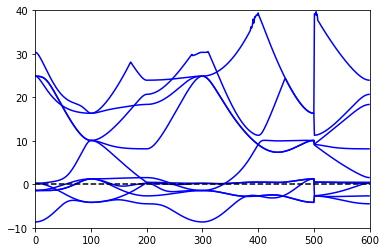

In [26]:
plt.plot(energy_sphinx[:-1], 'b-')
plt.axhline(y=0, ls='--', c='k')
plt.xlim(0, len(energy_sphinx));
plt.ylim(-10,40);